# 미니프로젝트 통합본 (팀원 코드 통합)
- 기준 노트북: **공복_혈당_회귀_분석.ipynb**
- 목적: 동일 CSV로 여러 통계분석을 **한 파일에서 오류 없이** 실행할 수 있도록 변수명/데이터 로딩을 통일


In [4]:
# 공통 라이브러리
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# (선택) Plotly가 설치돼 있으면 사용
try:
    import plotly.express as px
    import plotly.graph_objects as go
    _HAS_PLOTLY = True
except Exception:
    _HAS_PLOTLY = False
    print('⚠️ plotly 미설치: plotly 시각화는 건너뜁니다.')


In [5]:
# (선택) Google Colab에서 실행하고 Google Drive에 데이터가 있을 경우만 사용하세요.
# 로컬/VSCode/Jupyter에서는 아래 코드는 필요 없습니다.
#
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# 데이터 로딩 (통합본 공통)
import os
import pandas as pd

# (선택) 기존 Colab 경로가 있으면 여기에 넣어도 됩니다.
DATA_PATH = os.environ.get("DATA_PATH", "")  # 예: '/content/drive/MyDrive/.../프로젝트/'

CANDIDATE_PATHS = [
    "/mnt/data/diabetes_dataset.csv",  # ChatGPT/로컬 실행 환경
    os.path.join(os.getcwd(), "diabetes_dataset.csv"),
    os.path.join(os.getcwd(), "dataset", "diabetes_dataset.csv"),
]

if DATA_PATH:
    CANDIDATE_PATHS.append(os.path.join(DATA_PATH, "dataset", "diabetes_dataset.csv"))

CSV_PATH = next((p for p in CANDIDATE_PATHS if p and os.path.exists(p)), None)

if CSV_PATH is None:
    raise FileNotFoundError(
        "diabetes_dataset.csv 파일을 찾지 못했습니다. "
        "다음 경로 중 하나에 파일을 두거나, DATA_PATH 환경변수/변수를 설정하세요:\n"
        + "\n".join([f"- {p}" for p in CANDIDATE_PATHS if p])
    )

df = pd.read_csv(CSV_PATH)
print(f"✅ Loaded: {CSV_PATH}")
print("Data shape:", df.shape)

# diagnosed_diabetes(이진 타겟) 통일
# - 원본 데이터에 없으면 diabetes_stage 기반으로 생성
# - 정의: Type1/Type2/Gestational = 1 (진단), No Diabetes/Pre-Diabetes = 0
if "diagnosed_diabetes" not in df.columns:
    if "diabetes_stage" in df.columns:
        df["diagnosed_diabetes"] = df["diabetes_stage"].isin(["Type 1", "Type 2", "Gestational"]).astype(int)
        print("🧩 created df['diagnosed_diabetes'] from df['diabetes_stage']")
    else:
        raise KeyError("diagnosed_diabetes 컬럼이 없고 diabetes_stage도 없어 생성할 수 없습니다.")

In [7]:
# 기본 정보 확인
df.info()
display(df.isna().mean().sort_values(ascending=False).head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 100000 non-null  int64  
 1   gender                              100000 non-null  object 
 2   ethnicity                           100000 non-null  object 
 3   education_level                     100000 non-null  object 
 4   income_level                        100000 non-null  object 
 5   employment_status                   100000 non-null  object 
 6   smoking_status                      100000 non-null  object 
 7   alcohol_consumption_per_week        100000 non-null  int64  
 8   physical_activity_minutes_per_week  100000 non-null  int64  
 9   diet_score                          100000 non-null  float64
 10  sleep_hours_per_day                 100000 non-null  float64
 11  screen_time_hours_per_day  

,0
age,0.0
gender,0.0
ethnicity,0.0
education_level,0.0
income_level,0.0
employment_status,0.0
smoking_status,0.0
alcohol_consumption_per_week,0.0
physical_activity_minutes_per_week,0.0
diet_score,0.0


## 1) 공복 혈당 다중회귀분석 (공복_혈당_회귀_분석 기준)

In [8]:
cols_fasting = [
    'glucose_fasting','bmi','waist_to_hip_ratio','triglycerides',
    'hdl_cholesterol','systolic_bp','diastolic_bp','age'
]
df_fasting = df[cols_fasting].dropna().copy()

X = df_fasting.drop(columns='glucose_fasting')
y = df_fasting['glucose_fasting']
X = sm.add_constant(X)

model_fasting = sm.OLS(y, X).fit()
print(model_fasting.summary())


                            OLS Regression Results                            
Dep. Variable:        glucose_fasting   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     1140.
Date:                Tue, 06 Jan 2026   Prob (F-statistic):               0.00
Time:                        06:53:42   Log-Likelihood:            -3.9903e+05
No. Observations:              100000   AIC:                         7.981e+05
Df Residuals:                   99992   BIC:                         7.981e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 92.4126      1

In [9]:
# VIF (다중공선성 점검)
vif_df = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
display(vif_df)


,Variable,VIF
0,const,601.756138
1,bmi,2.743979
2,waist_to_hip_ratio,2.417624
3,triglycerides,1.197010
4,hdl_cholesterol,1.047033
5,systolic_bp,1.510982
6,diastolic_bp,1.059846
7,age,1.467528


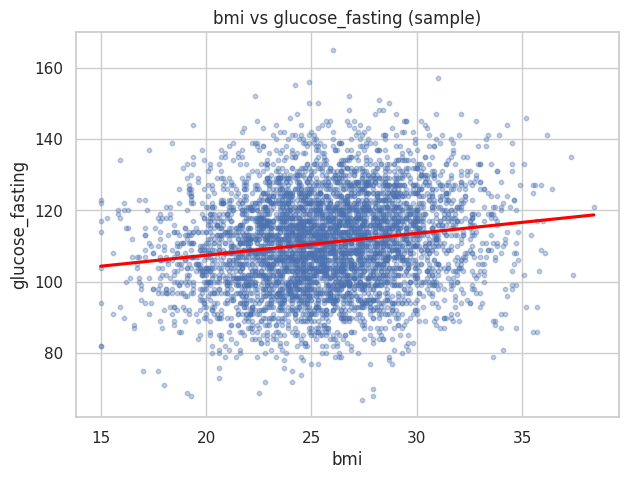

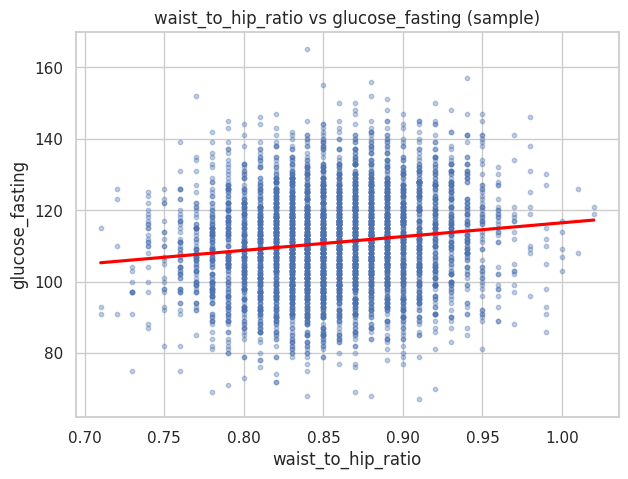

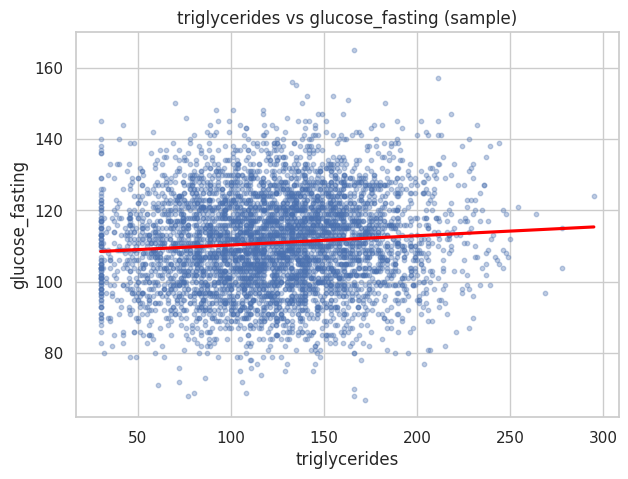

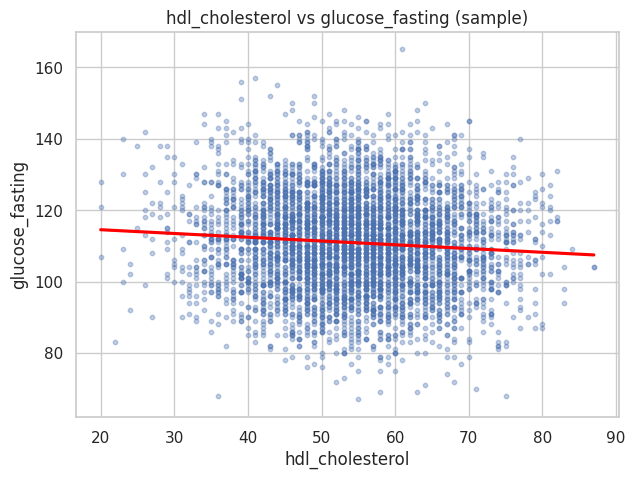

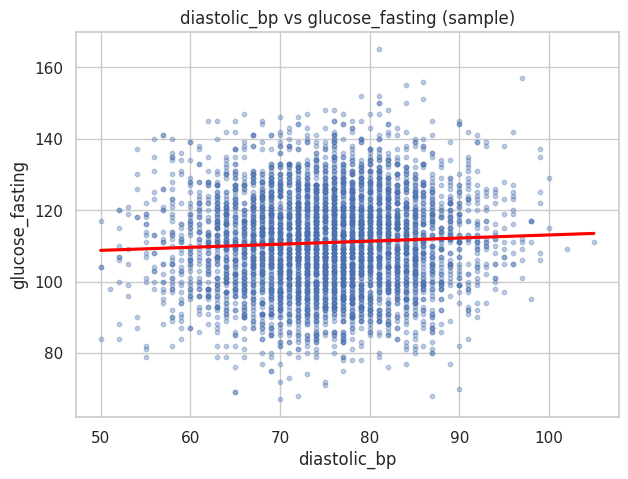

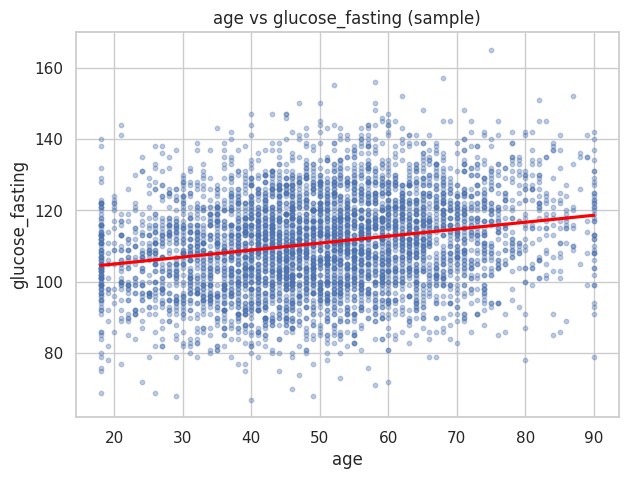

In [10]:
# 변수별 산점도 + 회귀선 (대용량 데이터이므로 샘플링 + CI 제거로 속도 개선)
df_fasting_plot = df_fasting.sample(n=min(5000, len(df_fasting)), random_state=42)

for var in ['bmi', 'waist_to_hip_ratio', 'triglycerides', 'hdl_cholesterol', 'diastolic_bp', 'age']:
    plt.figure(figsize=(7,5))
    sns.regplot(x=var, y='glucose_fasting', data=df_fasting_plot,
                scatter_kws={'alpha':0.35, 's':10}, line_kws={'color':'red'}, ci=None)
    plt.title(f"{var} vs glucose_fasting (sample)")
    plt.show()


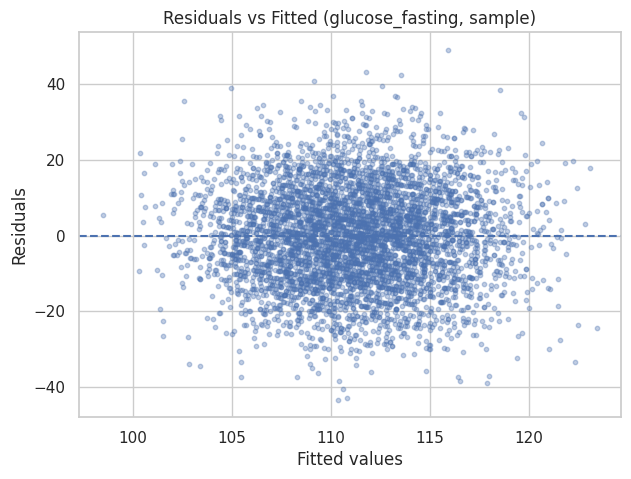

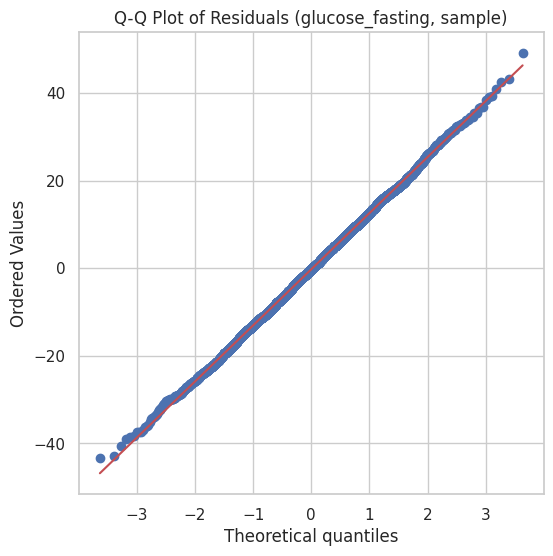

In [11]:
# 잔차 플롯 / Q-Q 플롯 (표본 5,000개로 시각화)
residuals = model_fasting.resid
fitted = model_fasting.fittedvalues

idx = np.random.RandomState(42).choice(len(residuals), size=min(5000, len(residuals)), replace=False)
res_s = residuals.iloc[idx] if hasattr(residuals, 'iloc') else residuals[idx]
fit_s = fitted.iloc[idx] if hasattr(fitted, 'iloc') else fitted[idx]

plt.figure(figsize=(7,5))
plt.scatter(fit_s, res_s, alpha=0.35, s=10)
plt.axhline(0, linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (glucose_fasting, sample)')
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(res_s, plot=plt)
plt.title('Q-Q Plot of Residuals (glucose_fasting, sample)')
plt.show()


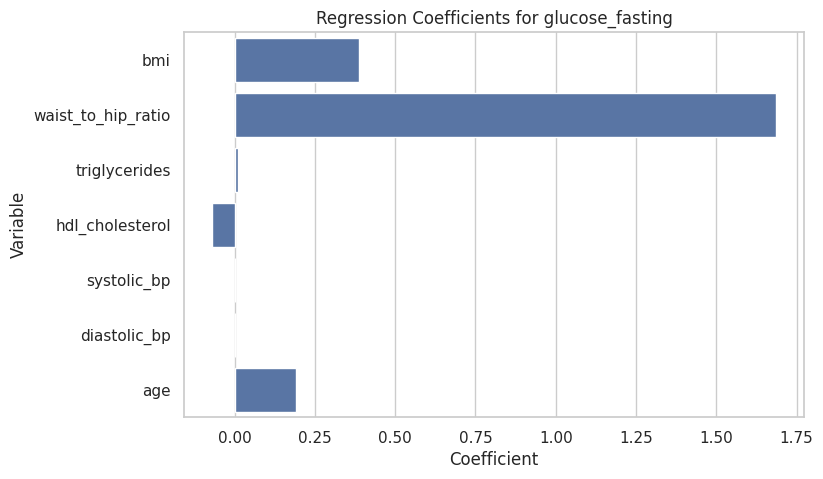

In [12]:
# 회귀계수 시각화
coef_df = pd.DataFrame({
    'Variable': model_fasting.params.index,
    'Coefficient': model_fasting.params.values
}).query("Variable != 'const'")

plt.figure(figsize=(8, 5))
sns.barplot(x='Coefficient', y='Variable', data=coef_df)
plt.title('Regression Coefficients for glucose_fasting')
plt.show()


## 2) HbA1c 분석 (시각화 + 회귀 + ANOVA)

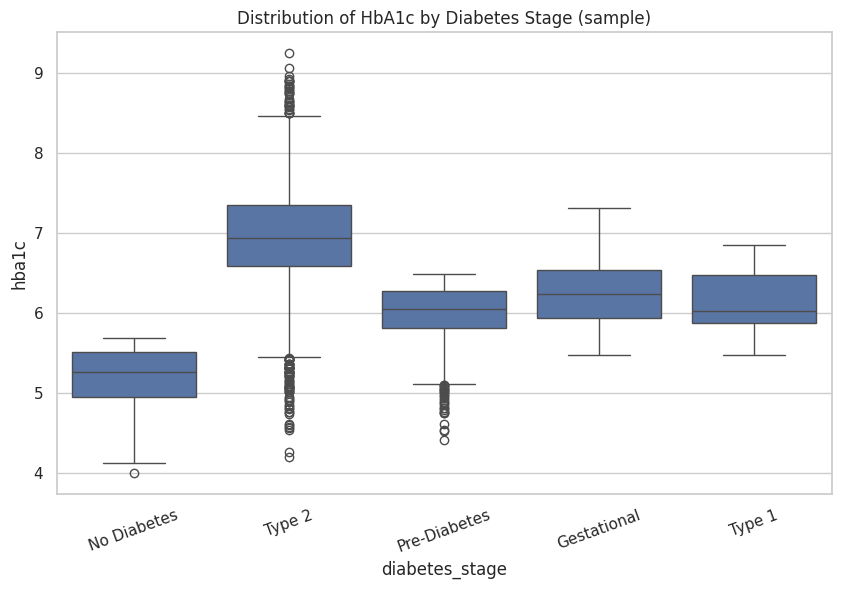

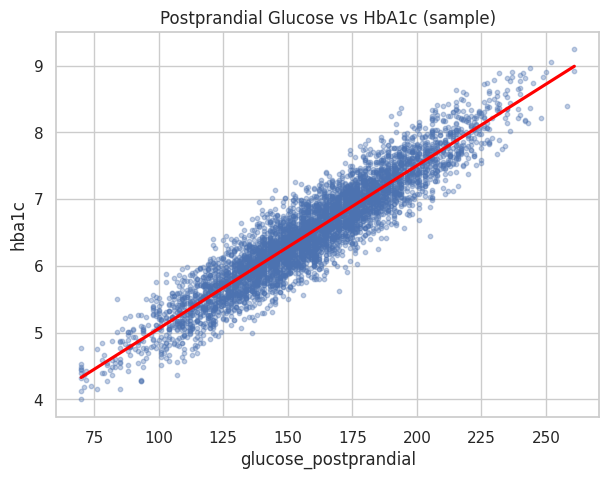

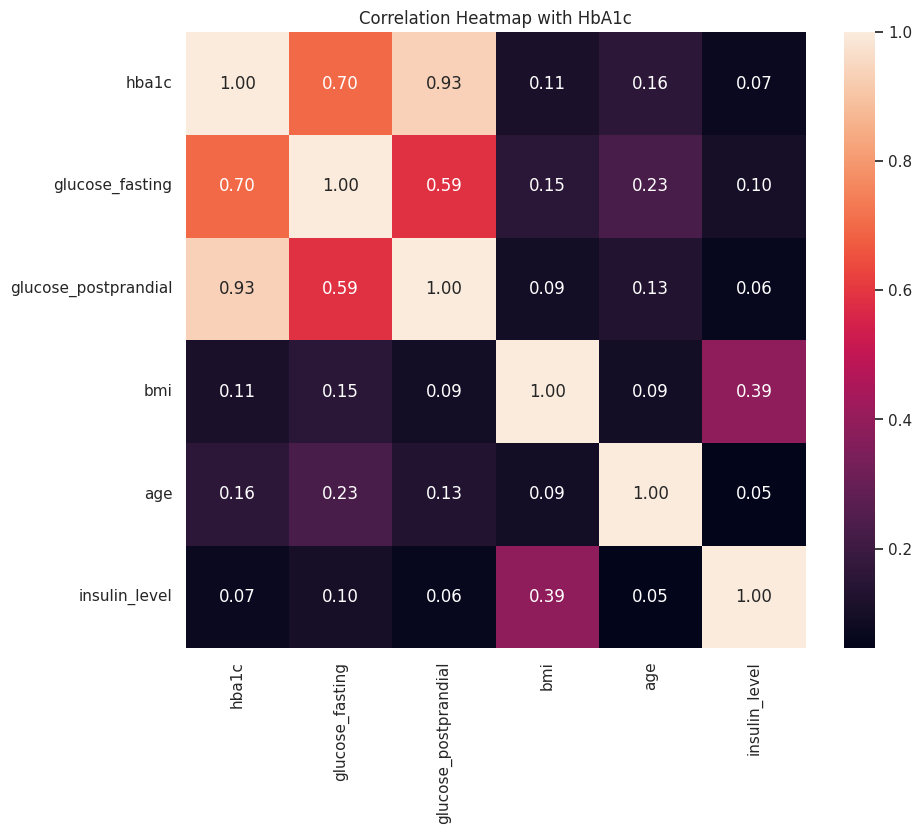

In [13]:
df_hba1c = df[['diabetes_stage','hba1c','glucose_postprandial','glucose_fasting','bmi','age','insulin_level','waist_to_hip_ratio']].dropna().copy()
df_hba_plot = df_hba1c.sample(n=min(5000, len(df_hba1c)), random_state=42)

plt.figure(figsize=(10, 6))
sns.boxplot(x='diabetes_stage', y='hba1c', data=df_hba_plot)
plt.title('Distribution of HbA1c by Diabetes Stage (sample)')
plt.xticks(rotation=20)
plt.show()

plt.figure(figsize=(7,5))
sns.regplot(x='glucose_postprandial', y='hba1c', data=df_hba_plot,
            scatter_kws={'alpha':0.35, 's':10}, line_kws={'color':'red'}, ci=None)
plt.title('Postprandial Glucose vs HbA1c (sample)')
plt.show()

plt.figure(figsize=(10, 8))
cols = ['hba1c', 'glucose_fasting', 'glucose_postprandial', 'bmi', 'age', 'insulin_level']
sns.heatmap(df_hba1c[cols].corr(), annot=True, fmt='.2f')
plt.title('Correlation Heatmap with HbA1c')
plt.show()


                            OLS Regression Results                            
Dep. Variable:                  hba1c   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 1.916e+05
Date:                Tue, 06 Jan 2026   Prob (F-statistic):               0.00
Time:                        06:53:44   Log-Likelihood:                -3344.2
No. Observations:              100000   AIC:                             6700.
Df Residuals:                   99994   BIC:                             6757.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.6061 

,0
age,0.000354
bmi,0.000370
waist_to_hip_ratio,0.001505
glucose_fasting,0.230363
glucose_postprandial,0.797239


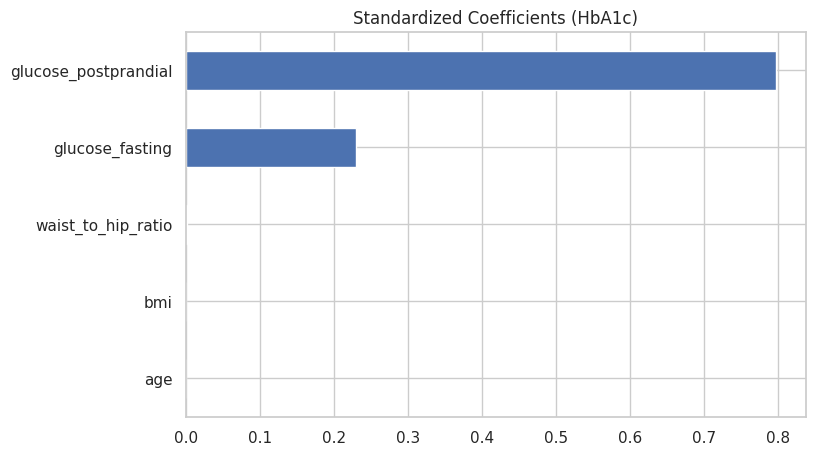

In [14]:
# HbA1c 선형회귀
features_hba1c = ['glucose_fasting', 'glucose_postprandial', 'bmi', 'age', 'waist_to_hip_ratio']
df_hba_reg = df[features_hba1c + ['hba1c']].dropna().copy()

X_hba = sm.add_constant(df_hba_reg[features_hba1c])
y_hba = df_hba_reg['hba1c']
model_hba1c = sm.OLS(y_hba, X_hba).fit()
print(model_hba1c.summary())

# 표준화 회귀계수
zX = (df_hba_reg[features_hba1c] - df_hba_reg[features_hba1c].mean()) / df_hba_reg[features_hba1c].std(ddof=0)
zy = (y_hba - y_hba.mean()) / y_hba.std(ddof=0)
model_hba1c_std = sm.OLS(zy, sm.add_constant(zX)).fit()
std_coef = model_hba1c_std.params.drop('const').sort_values()
display(std_coef)
plt.figure(figsize=(8,5))
std_coef.plot(kind='barh')
plt.title('Standardized Coefficients (HbA1c)')
plt.show()


In [15]:
# ANOVA: 당뇨 단계별 HbA1c 평균 차이
groups = [df_hba1c[df_hba1c['diabetes_stage'] == s]['hba1c'].dropna() for s in df_hba1c['diabetes_stage'].unique()]
f_val, p_val = stats.f_oneway(*groups)
print(f"[ANOVA] F-stat: {f_val:.3f} | p-value: {p_val:.3e}")


[ANOVA] F-stat: 27387.422 | p-value: 0.000e+00


## 3) 인슐린 수치 회귀분석 (insulin_level)

                            OLS Regression Results                            
Dep. Variable:          insulin_level   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     3683.
Date:                Tue, 06 Jan 2026   Prob (F-statistic):               0.00
Time:                        06:53:45   Log-Likelihood:            -2.9346e+05
No. Observations:              100000   AIC:                         5.869e+05
Df Residuals:                   99994   BIC:                         5.870e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -6.3247 

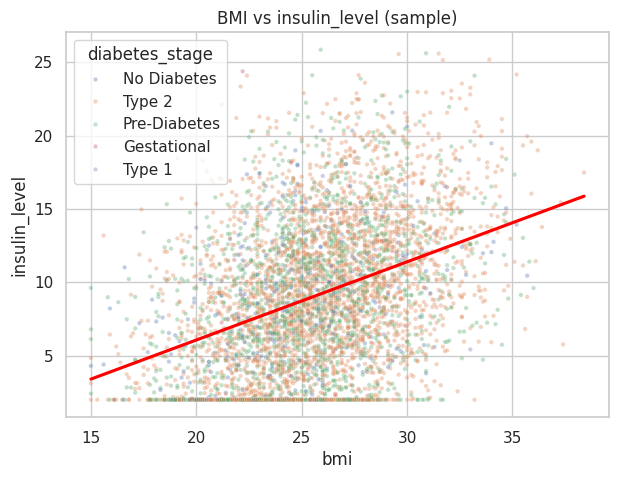

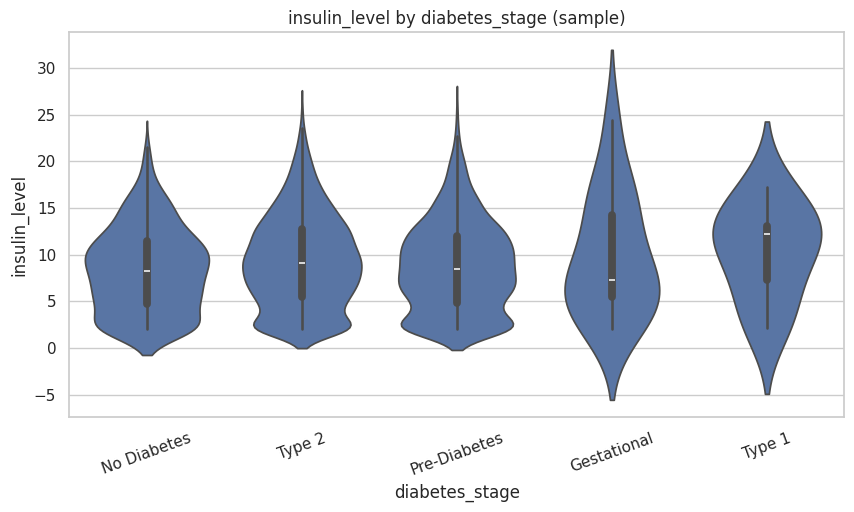

In [16]:
features_insulin = ['glucose_fasting', 'glucose_postprandial', 'bmi', 'age', 'hba1c']
df_ins = df[features_insulin + ['insulin_level','diabetes_stage']].dropna().copy()

X_ins = sm.add_constant(df_ins[features_insulin])
y_ins = df_ins['insulin_level']
model_insulin = sm.OLS(y_ins, X_ins).fit()
print(model_insulin.summary())

df_ins_plot = df_ins.sample(n=min(5000, len(df_ins)), random_state=42)
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_ins_plot, x='bmi', y='insulin_level', hue='diabetes_stage', alpha=0.35, s=10)
sns.regplot(data=df_ins_plot, x='bmi', y='insulin_level', scatter=False, color='red', ci=None)
plt.title('BMI vs insulin_level (sample)')
plt.show()

plt.figure(figsize=(10,5))
sns.violinplot(data=df_ins_plot, x='diabetes_stage', y='insulin_level')
plt.xticks(rotation=20)
plt.title('insulin_level by diabetes_stage (sample)')
plt.show()

if _HAS_PLOTLY:
    fig = px.scatter_3d(df_ins_plot, x='glucose_postprandial', y='insulin_level', z='hba1c', color='diabetes_stage',
                        title='Postprandial glucose, insulin_level, HbA1c (3D, sample)')
    fig.show()


## 4) 로지스틱 회귀분석 (diagnosed_diabetes)

In [17]:
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

features_diag = ['glucose_fasting', 'glucose_postprandial', 'bmi', 'age', 'waist_to_hip_ratio']
df_diag = df[features_diag + ['diagnosed_diabetes']].dropna().copy()

X_diag = sm.add_constant(df_diag[features_diag])
y_diag = df_diag['diagnosed_diabetes']

model_diag = sm.Logit(y_diag, X_diag).fit(disp=0)
print(model_diag.summary())

odds_ratio = np.exp(model_diag.params)
print('\n[변수별 오즈비(Odds Ratio)]')
display(odds_ratio)

proba = model_diag.predict(X_diag)
pred = (proba >= 0.5).astype(int)
auc = roc_auc_score(y_diag, proba)
cm = confusion_matrix(y_diag, pred)
acc = accuracy_score(y_diag, pred)
prec = precision_score(y_diag, pred)
rec = recall_score(y_diag, pred)
f1 = f1_score(y_diag, pred)
print(f"AUC={auc:.4f} | Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f}")
print('Confusion matrix:\n', cm)


                           Logit Regression Results                           
Dep. Variable:     diagnosed_diabetes   No. Observations:               100000
Model:                          Logit   Df Residuals:                    99994
Method:                           MLE   Df Model:                            5
Date:                Tue, 06 Jan 2026   Pseudo R-squ.:                  0.4260
Time:                        06:53:48   Log-Likelihood:                -38632.
converged:                       True   LL-Null:                       -67302.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -17.2784      0.221    -78.161      0.000     -17.712     -16.845
glucose_fasting          0.0609      0.001     67.552      0.000       0.059       0.063
glucose_post

,0
const,3.133921e-08
glucose_fasting,1.062775e+00
glucose_postprandial,1.066285e+00
bmi,1.012240e+00
age,1.005380e+00
waist_to_hip_ratio,1.712929e+00


AUC=0.9116 | Acc=0.8334 | Prec=0.8497 | Rec=0.8776 | F1=0.8634
Confusion matrix:
 [[30687  9315]
 [ 7343 52655]]


## 5) 다항 로지스틱 (diabetes_stage)

In [18]:
df_stage = df[['diabetes_stage','glucose_fasting','glucose_postprandial','bmi','age']].dropna().copy()
stage_cat = pd.Categorical(df_stage['diabetes_stage'])
y_stage = stage_cat.codes
stage_mapping = dict(enumerate(stage_cat.categories))
print('Stage mapping:', stage_mapping)

X_stage = sm.add_constant(df_stage[['glucose_fasting','glucose_postprandial','bmi','age']])
model_stage = sm.MNLogit(y_stage, X_stage).fit(method='newton', disp=0)
print(model_stage.summary())


Stage mapping: {0: 'Gestational', 1: 'No Diabetes', 2: 'Pre-Diabetes', 3: 'Type 1', 4: 'Type 2'}
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:               100000
Model:                        MNLogit   Df Residuals:                    99980
Method:                           MLE   Df Model:                           16
Date:                Tue, 06 Jan 2026   Pseudo R-squ.:                  0.4327
Time:                        06:54:00   Log-Likelihood:                -50958.
converged:                       True   LL-Null:                       -89831.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 y=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   35.7843      0.838     42.683      0.000      34.141      37.427
gluc

## 6) 카이제곱 검정 (범주형 변수 ↔ diagnosed_diabetes)

In [19]:
from scipy.stats import chi2_contingency

target = 'diagnosed_diabetes'

def chi2_test(feature: str):
    ct = pd.crosstab(df[feature], df[target])
    chi2, p, dof, expected = chi2_contingency(ct)
    return {'feature': feature, 'p_value': p, 'dof': dof}

cat_features = ['gender', 'ethnicity', 'smoking_status', 'hypertension_history']
results = [chi2_test(col) for col in cat_features if col in df.columns]
res_df = pd.DataFrame(results).sort_values('p_value')
display(res_df)

ct = pd.crosstab(df['hypertension_history'], df['diagnosed_diabetes'])
display(ct)
chi2, p, dof, expected = chi2_contingency(ct)
print(f"[Hypertension vs Diabetes] p-value={p:.4e} | dof={dof}")


,feature,p_value,dof
3,hypertension_history,3.424198e-18,1
0,gender,9.880537e-02,2
1,ethnicity,3.211829e-01,4
2,smoking_status,9.272422e-01,2


diagnosed_diabetes,0,1
hypertension_history,,
0,30554,44366
1,9448,15632


[Hypertension vs Diabetes] p-value=3.4242e-18 | dof=1


## 7) 인슐린 수치 다중선형회귀분석 및 당뇨 진단 여부 로지스틱 회귀 분석

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)

sns.set(style='whitegrid')


Data shape: (100000, 31)

Columns:
Index(['age', 'gender', 'ethnicity', 'education_level', 'income_level',
       'employment_status', 'smoking_status', 'alcohol_consumption_per_week',
       'physical_activity_minutes_per_week', 'diet_score',
       'sleep_hours_per_day', 'screen_time_hours_per_day',
       'family_history_diabetes', 'hypertension_history',
       'cardiovascular_history', 'bmi', 'waist_to_hip_ratio', 'systolic_bp',
       'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol',
       'ldl_cholesterol', 'triglycerides', 'glucose_fasting',
       'glucose_postprandial', 'insulin_level', 'hba1c', 'diabetes_risk_score',
       'diabetes_stage', 'diagnosed_diabetes'],
      dtype='object')

Target (Logistic) distribution:
diagnosed_diabetes
1    59998
0    40002
Name: count, dtype: int64

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                              Non-Null C

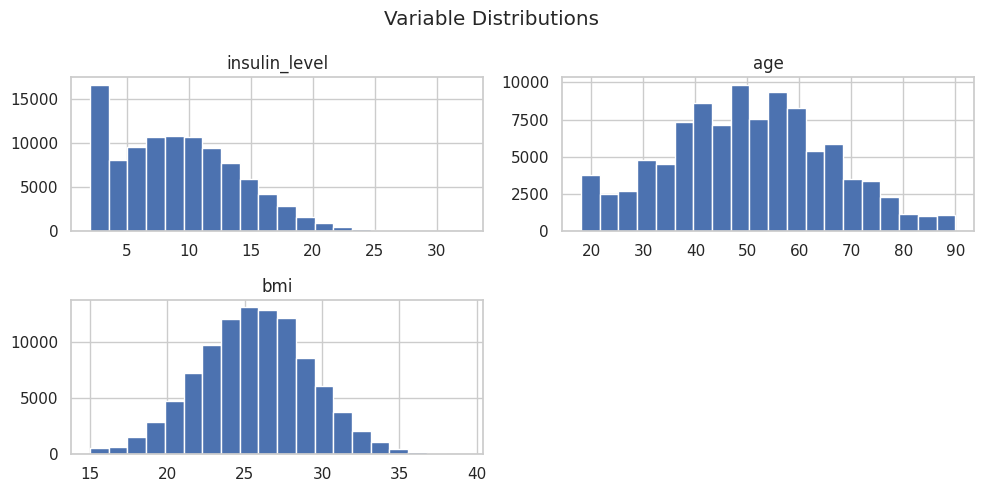

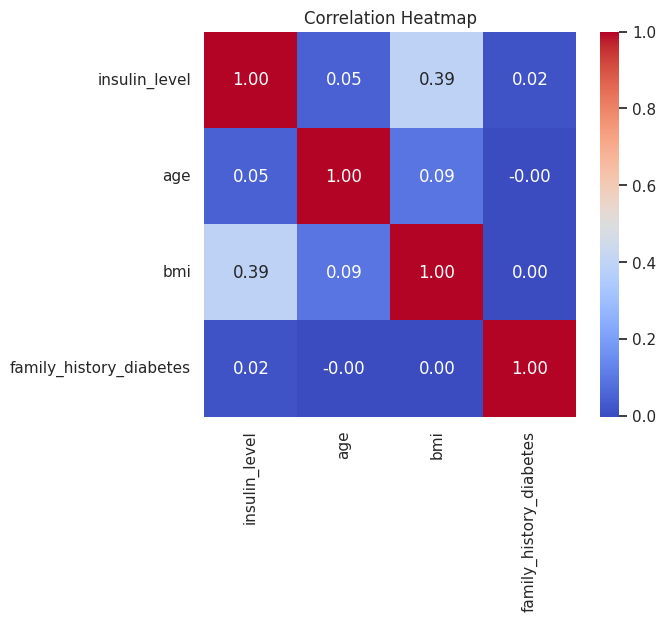

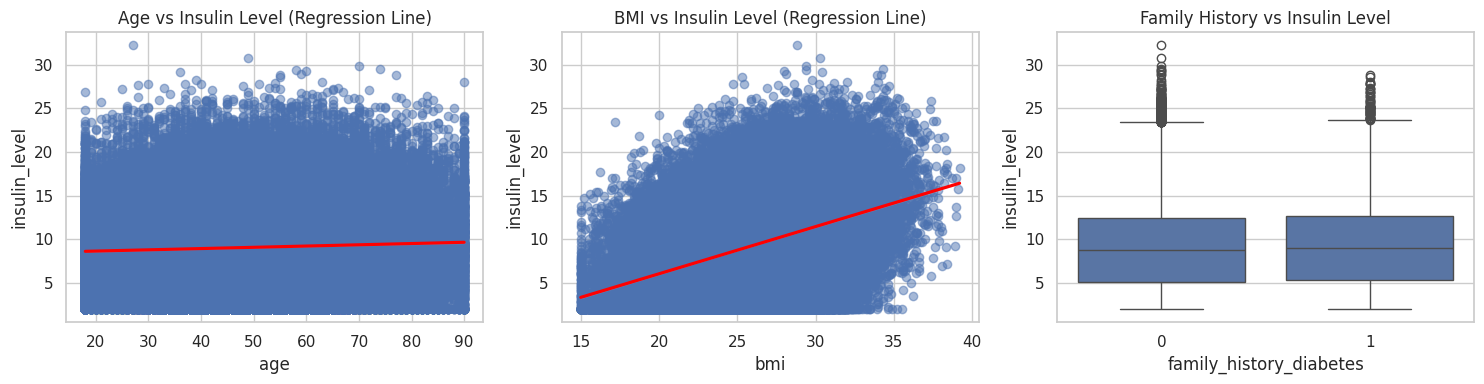


===== Multiple Linear Regression (OLS) =====
                            OLS Regression Results                            
Dep. Variable:          insulin_level   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     6064.
Date:                Tue, 06 Jan 2026   Prob (F-statistic):               0.00
Time:                        06:54:15   Log-Likelihood:            -2.9356e+05
No. Observations:              100000   AIC:                         5.871e+05
Df Residuals:                   99996   BIC:                         5.872e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

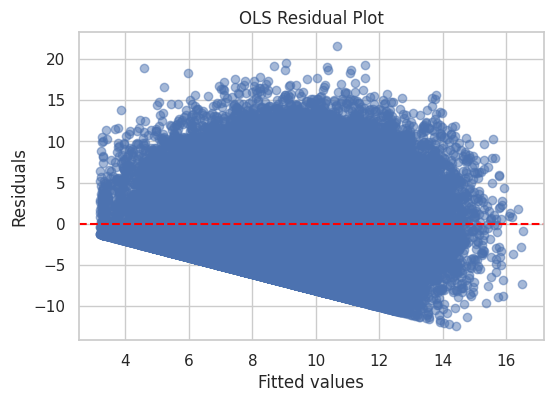

Optimization terminated successfully.
         Current function value: 0.638329
         Iterations 5

===== Logistic Regression =====
                           Logit Regression Results                           
Dep. Variable:     diagnosed_diabetes   No. Observations:               100000
Model:                          Logit   Df Residuals:                    99996
Method:                           MLE   Df Model:                            3
Date:                Tue, 06 Jan 2026   Pseudo R-squ.:                 0.05155
Time:                        06:54:15   Log-Likelihood:                -63833.
converged:                       True   LL-Null:                       -67302.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.0373      0.052    

In [21]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm


# df는 앞에서 통일된 경로(CSV_PATH)로 이미 로드되어 있습니다.
# (원본 코드의 로딩 라인: df = pd.read_csv(DATA_PATH + 'dataset/diabetes.csv') )

print("Data shape:", df.shape)
print("\nColumns:")
print(df.columns)


target_logistic = "diagnosed_diabetes"

print("\nTarget (Logistic) distribution:")
print(df[target_logistic].value_counts())

print("\nData info:")
print(df.info())

print("\nBasic statistics:")
print(df.describe())


cols = [
    'insulin_level',
    'age',
    'bmi',
    'family_history_diabetes',
    'diagnosed_diabetes'
]

df_model = df[cols].copy()

print("\nMissing values:")
print(df_model.isnull().sum())

df_model = df_model.dropna()


df_model[['insulin_level', 'age', 'bmi']].hist(figsize=(10, 5), bins=20)
plt.suptitle("Variable Distributions")
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 5))
sns.heatmap(
    df_model[['insulin_level', 'age', 'bmi', 'family_history_diabetes']].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Heatmap")
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.regplot(
    ax=axes[0],
    x='age',
    y='insulin_level',
    data=df_model,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

sns.regplot(
    ax=axes[1],
    x='bmi',
    y='insulin_level',
    data=df_model,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

sns.boxplot(
    ax=axes[2],
    x='family_history_diabetes',
    y='insulin_level',
    data=df_model
)

axes[0].set_title("Age vs Insulin Level (Regression Line)")
axes[1].set_title("BMI vs Insulin Level (Regression Line)")
axes[2].set_title("Family History vs Insulin Level")

plt.tight_layout()
plt.show()


ols_model = smf.ols(
    formula='insulin_level ~ age + bmi + family_history_diabetes',
    data=df_model
).fit()

print("\n===== Multiple Linear Regression (OLS) =====")
print(ols_model.summary())


fitted = ols_model.fittedvalues
residuals = ols_model.resid

plt.figure(figsize=(6, 4))
plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("OLS Residual Plot")
plt.show()


logit_model = smf.logit(
    formula='diagnosed_diabetes ~ age + bmi + family_history_diabetes',
    data=df_model
).fit()

print("\n===== Logistic Regression =====")
print(logit_model.summary())


params = logit_model.params
odds_ratio = np.exp(params)

odds_df = pd.DataFrame({
    "Coefficient": params,
    "Odds Ratio": odds_ratio
})

print("\n===== Odds Ratio =====")
print(odds_df)


log_ols_model = smf.ols(
    formula='np.log(insulin_level) ~ age + bmi + family_history_diabetes',
    data=df_model
).fit()

print("\n===== Log-Transformed OLS =====")
print(log_ols_model.summary())


# 7) 머신러닝 분류 모델링 (통합)

# 머신러닝 분석

# Google Drive 연결

# 라이브러리

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, classification_report
)

# 데이터 가져오기

In [ ]:
# 머신러닝 파트용 데이터 준비
# - 통계분석 파트에서 이미 df를 로드했고, df['diagnosed_diabetes']도 통일했습니다.
target = "diagnosed_diabetes"

train_df = df.copy()

# (선택) 제출/예측 파일을 만들고 싶다면, 타겟을 제거한 feature-only 데이터프레임을 test_df로 사용
test_df = df.drop(columns=[target], errors="ignore").copy()

print("train_df:", train_df.shape, "| test_df:", test_df.shape)
print("Target distribution:\n", train_df[target].value_counts())

# 데이터 분리

In [ ]:
X = train_df.drop(["id", target], axis=1, errors="ignore")
y = train_df[target]

X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 탐색적 분석 (통계 분석)
- 코드 진행
-

# 전처리 설계

In [ ]:
# Ordinal Encoding
target_ordinal = ['income_level']  # 순서형 자료
income_cats = ['Low', 'Lower-Middle', 'Middle', 'Upper-Middle', 'High']

# OneHot Encoding 컬럼들 (object 타입)
categorical_features = X_train_raw.select_dtypes(include=['object']).columns.tolist()

# 순서형 자료 컬럼은 범주형에서 제거
categorical_features = list(set(categorical_features) - set(target_ordinal))

# 수치형 컬럼들
numeric_features = X_train_raw.select_dtypes(include=np.number).columns.tolist()

# 수치형 자료에서 bmi 제거하기로 함
# 회귀분석 진행했더니 waist_to_hip_ratio 영향도가 더 높아 bmi는 제외
remove_features = ['bmi']
numeric_features = list(set(numeric_features) - set(remove_features))

# 전처리기 생성
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("ord", OrdinalEncoder(
            categories=[income_cats],
            handle_unknown="use_encoded_value",
            unknown_value=-1
        ), target_ordinal)
    ]
)

preprocessor


# 모델 개발 및 하이퍼파라미터 설정
- 랜덤서치는 확률분포나 범위 지정 가능

1. 클래스 불균형 처리를 위한 비율 계산 (`ratio`)
- **의미**: 학습 데이터(`y_train`) 내 다수 클래스(0: 정상) 대비 소수 클래스(1: 당뇨)의 비율을 산출합니다.
- **용도**: 데이터 불균형이 심할 때, 모델이 소수 클래스에 더 가중치를 두어 학습하도록 돕는 지표로 활용됩니다.



2. 로지스틱 회귀(Logistic Regression) 설정
- **의미**: 선형 분류 모델을 기반으로 하이퍼파라미터 탐색 범위를 정의합니다.
- **`class_weight="balanced"`**: 데이터 빈도에 반비례하여 가중치를 자동 부여하여 불균형을 해결합니다.
- **`model__C`**: 규제(Regularization) 강도의 역수입니다. 값이 작을수록 더 강력한 규제를 적용합니다.

3. 결정 트리(Decision Tree) 설정
- **의미**: 데이터 규칙을 나무 구조로 시각화하는 비선형 모델의 탐색 공간을 정의합니다.
- **`model__max_depth`**: 나무의 최대 깊이를 제한하여 모델이 너무 복잡해지는 것(과적합)을 방지합니다.
- **`model__min_samples_leaf`**: 리프 노드(말단)가 되기 위한 최소 샘플 수로, 가지치기의 역할을 수행합니다.



4. XGBoost 설정
- **의미**: 성능이 우수한 그래디언트 부스팅(GBDT) 알고리즘의 최적 파라미터를 탐색합니다.
- **`scale_pos_weight=ratio`**: 앞서 계산한 클래스 비율을 적용하여 양성 클래스(1)에 대한 가중치를 직접 조절합니다.
- **`model__learning_rate`**: 각 단계에서 오차를 보정하는 보폭을 결정하며, `max_depth` 및 `n_estimators`와 결합하여 성능을 최적화합니다.
- **`model__subsample`**: 나무를 만들 때 사용하는 무작위 샘플링 비율로, 모델의 일반화 성능을 높입니다.

In [ ]:
ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(ratio)

model_configs = [
    {
        "name": "Logistic Regression",
        "model": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
        "params": {
            "model__C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], # 규제 강도 무작위 탐색
            "model__penalty": ['l2']
        }
    },
    {
        "name": "Decision Tree",
        "model": DecisionTreeClassifier(class_weight="balanced", random_state=42),
        "params": {
            "model__max_depth": np.arange(3, 16), # 3~15 사이 무작위 탐색
            "model__min_samples_leaf": [10, 20, 30, 50, 100]
        }
    },
    {
        "name": "XGBoost",
        "model": XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1, scale_pos_weight=ratio),
        "params": {
            "model__n_estimators": [100, 200, 300, 400],
            "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
            "model__max_depth": [3, 4, 5, 6],
            "model__subsample": [0.7, 0.8, 0.9]
        }
    },
    {
        "name": "LightGBM",
        "model": LGBMClassifier(random_state=42, n_jobs=-1, scale_pos_weight=ratio, verbosity=-1),
        "params": {
            "model__n_estimators": [100, 200, 300, 400],
            "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
            "model__subsample": [0.7, 0.8, 0.9],
            "model__max_depth": [3, 4, 5, 6]
        }
    }
]

# Random Search 학습 진행

In [ ]:
import time
from datetime import timedelta
import warnings
from tqdm.auto import tqdm # 진행 바 라이브러리

warnings.filterwarnings('ignore', category=UserWarning)

# 1. 교차 검증 및 결과 저장 준비
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# 2. 전체 모델 루프에 tqdm 적용 (전체 진행률 확인)
for config in tqdm(model_configs, desc="전체 모델 최적화 진행 중"):
    print(f"\n [{config['name']}] 랜덤 서치 탐색을 시작합니다...")

    # 시간 측정 시작
    start_time = time.perf_counter()

    pipeline = Pipeline([("prep", preprocessor), ("model", config['model'])])

    # RandomizedSearchCV 설정
    # verbose=1: 간단한 진행 상황 출력 (각 파라미터 조합 시도 시 출력)
    # n_jobs=-1: 병렬 처리 활성화
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=config['params'],
        n_iter=10,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        verbose=1 # <--- 실행 중인 상태를 로그로 보여줍니다.
    )

    # 모델 학습 (실제 탐색 수행)
    search.fit(X_train_raw, y_train)

    # 시간 측정 종료 및 변환
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    elapsed_hms = str(timedelta(seconds=int(elapsed_time)))

    # 검증셋 평가
    val_probs = search.predict_proba(X_val_raw)[:, 1]
    val_auc = roc_auc_score(y_val, val_probs)
    val_pred = search.predict(X_val_raw)

    # 상세 지표 계산
    tn, fp, fn, tp = confusion_matrix(y_val, val_pred).ravel()

    print(f"[{config['name']}] 탐색 완료!")
    print(f"소요 시간: {elapsed_hms} | Best CV AUC: {search.best_score_:.4f} | Val AUC: {val_auc:.4f}")

    # 결과 저장
    results.append({
        "Model": config['name'],
        "AUC": roc_auc_score(y_val, val_probs),
        "Accuracy": accuracy_score(y_val, val_pred),
        "Precision": precision_score(y_val, val_pred),
        "Recall": recall_score(y_val, val_pred),
        "F1": f1_score(y_val, val_pred),
        "TP": tp, "TN": tn, "FP": fp, "FN": fn,
        "Best_CV_AUC": search.best_score_,
        "Val_AUC": val_auc,
        "Time": elapsed_hms,
        "Best_Params": search.best_params_
    })

# 결과 확인

In [ ]:
# 결과 확인
import pandas as pd
results_df = pd.DataFrame(results)
results_df

# SVM or RandomForest 정도 모델 하나 추가

In [ ]:
display(results_df[["Model", "Best_CV_AUC", "Val_AUC", "Time"]])

In [ ]:
# ===== best pipeline 자동 탐색 + (필요 시) fit: NameError 방지 버전 =====
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted

# 1) best_lgbm가 없으면, 노트북에 존재하는 파이프라인 후보를 찾아서 base_pipeline로 연결
candidate_names = [
    "best_lgbm", "final_pipeline",
    "best_model", "best_pipeline", "best_estimator",
    "lgbm_pipeline", "pipeline", "clf_pipeline"
]

base_name = next((n for n in candidate_names if n in globals()), None)
if base_name is None:
    raise NameError(
        "학습/평가할 파이프라인 변수를 찾을 수 없습니다.\n"
        "위쪽 셀에서 최적 모델 파이프라인을 만든 뒤 실행하세요.\n"
        f"찾는 후보 변수명: {candidate_names}"
    )

base_pipeline = globals()[base_name]
print(f"✅ 사용 파이프라인: {base_name}")

# 2) 학습 여부 확인 후, 미학습이면 fit (중복 학습 방지)
try:
    if hasattr(base_pipeline, "named_steps") and "model" in base_pipeline.named_steps:
        check_is_fitted(base_pipeline.named_steps["model"])
    else:
        check_is_fitted(base_pipeline)
    print(f"{base_name}: 이미 학습된 상태입니다. (fit 생략)")
except (NotFittedError, Exception):
    print(f"{base_name}: 학습되지 않은 상태라 fit을 수행합니다.")
    base_pipeline.fit(X_train_raw, y_train)

# (선택) 이후 코드가 best_lgbm 이름을 기대한다면 호환용으로 연결
best_lgbm = base_pipeline


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.base import clone

# 1) base 모델(원본 파이프라인) 자동 찾기: best_lgbm가 없으면 다른 이름도 탐색
candidate_names = ["best_lgbm", "final_pipeline", "best_pipeline", "best_model"]
base_name = next((n for n in candidate_names if n in globals()), None)
if base_name is None:
    raise NameError("원본 파이프라인(best_lgbm/final_pipeline 등)을 찾을 수 없습니다. 위쪽 최종모델 생성 셀부터 실행하세요.")

base_pipeline = globals()[base_name]

# 2) reduced가 없으면 만들어서 fit
if "best_lgbm_reduced" not in globals():

    # remove_features가 없으면 기본값(너가 쓰던 값)으로 생성
    if "remove_features" not in globals():
        remove_features = ["alcohol_consumption_per_week", "sleep_hours_per_day", "diastolic_bp"]

    # 필요한 피처 리스트 체크
    required = ["numeric_features", "categorical_features", "target_ordinal", "income_cats",
                "X_train_raw", "y_train"]
    missing = [v for v in required if v not in globals()]
    if missing:
        raise NameError(f"다음 변수가 필요합니다(위쪽 셀 먼저 실행): {missing}")

    numeric_features_reduced = [f for f in numeric_features if f not in remove_features]

    preprocessor_reduced = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features_reduced),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
            ("ord", OrdinalEncoder(
                categories=[income_cats],
                handle_unknown="use_encoded_value",
                unknown_value=-1
            ), target_ordinal)
        ],
        remainder="drop"
    )

    # 원본 파이프라인의 model을 그대로 복제(탐색 다시 안 함)
    if not hasattr(base_pipeline, "named_steps") or "model" not in base_pipeline.named_steps:
        raise KeyError(f"{base_name} 파이프라인에서 named_steps['model']을 찾을 수 없습니다. step 이름을 확인하세요.")

    reduced_model = clone(base_pipeline.named_steps["model"])

    best_lgbm_reduced = Pipeline(
        steps=[
            ("prep", preprocessor_reduced),
            ("model", reduced_model)
        ]
    )

    # fit (검증용: train만으로 학습)
    best_lgbm_reduced.fit(X_train_raw, y_train)

    print("✅ best_lgbm_reduced 생성 및 학습 완료")
else:
    print("✅ best_lgbm_reduced 이미 존재함(재생성/재학습 생략)")


In [ ]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)
import time

start_time = time.time()

# Validation 예측
y_val_proba = best_lgbm_reduced.predict_proba(X_val_raw)[:, 1]
y_val_pred = (y_val_proba >= 0.5).astype(int)

# 지표 계산
auc = roc_auc_score(y_val, y_val_proba)
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()

elapsed_time = time.time() - start_time


In [ ]:
# best_model_info가 없을 수 있으니 안전하게 처리
best_cv_auc = None
best_params = None

if "best_model_info" in globals() and isinstance(best_model_info, dict):
    best_cv_auc = best_model_info.get("Best_CV_AUC", None)
    best_params = best_model_info.get("Best_Params", None)
elif "search" in globals() and hasattr(search, "best_score_") and hasattr(search, "best_params_"):
    # RandomizedSearchCV/GridSearchCV를 search 변수로 쓰는 경우 대체
    best_cv_auc = search.best_score_
    best_params = search.best_params_

reduced_row = {
    "Model": "LightGBM (Reduced)",
    "AUC": auc,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1": f1,
    "TP": tp,
    "TN": tn,
    "FP": fp,
    "FN": fn,
    "Best_CV_AUC": best_cv_auc,   # ✅ best_model_info 없으면 None
    "Val_AUC": auc,
    "Time": f"{elapsed_time:.2f}s",
    "Best_Params": best_params    # ✅ best_model_info 없으면 None
}


In [ ]:
results_df = pd.concat(
    [results_df, pd.DataFrame([reduced_row])],
    ignore_index=True
)

display(results_df[["Model", "Best_CV_AUC", "Val_AUC", "Time"]])


In [ ]:
y_val_pred_orig = best_lgbm.predict_proba(X_val_raw)[:, 1]
auc_orig = roc_auc_score(y_val, y_val_pred_orig)

y_val_pred_reduced = best_lgbm_reduced.predict_proba(X_val_raw)[:, 1]
auc_reduced = roc_auc_score(y_val, y_val_pred_reduced)


In [ ]:
remove_features = [
    "alcohol_consumption_per_week",
    "sleep_hours_per_day",
    "diastolic_bp"
]

numeric_features_reduced = [
    f for f in numeric_features if f not in remove_features
]


In [ ]:
preprocessor_reduced = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_reduced),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("ord", OrdinalEncoder(
            categories=[income_cats],
            handle_unknown="use_encoded_value",
            unknown_value=-1
        ), target_ordinal)
    ]
)


In [ ]:
best_lgbm_final = Pipeline(
    steps=[
        ("prep", preprocessor_reduced),
        ("model", LGBMClassifier(
            n_estimators=400,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            scale_pos_weight=ratio,
            random_state=42
        ))
    ]
)

best_lgbm_final.fit(X, y)   # X_train + X_val 전체


# 제출 파일 생성코드

In [ ]:
# 1. 랜덤 서치 결과 중 가장 성능(Val_AUC)이 좋은 모델 정보 가져오기
best_model_info = max(results, key=lambda x: x['Val_AUC'])
best_model_name = best_model_info['Model']
best_params = best_model_info['Best_Params']

print(f"🏆 최종 선택된 모델: {best_model_name}")
print(f"⚙️ 최적 하이퍼파라미터: {best_params}")

# 2. 최적 모델 객체 찾기 및 파라미터 적용
# model_configs 리스트에서 이름이 같은 모델 설정을 찾습니다.
selected_config = next(config for config in model_configs if config["name"] == best_model_name)
final_model_obj = selected_config["model"]

# 파생된 파이프라인 생성 (전처리기 + 선택된 모델)
final_pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", final_model_obj)
])

# RandomizedSearchCV에서 찾은 'best_params'를 파이프라인에 직접 주입합니다.
final_pipeline.set_params(**best_params)

# 3. 전체 데이터로 재학습 (Train + Validation 합쳐서 학습하면 성능이 더 좋아집니다)
# 강의용이라면 간단하게 X_train_raw만 사용해도 무방합니다.
print("최적 파라미터로 모델 재학습 중...")
final_pipeline.fit(X_train_raw, y_train)

# 4. 테스트 데이터 예측
test_X = test_df.drop(["id"], axis=1, errors="ignore")
test_proba = final_pipeline.predict_proba(test_X)[:, 1]

# 5. 제출 데이터프레임 구성
submission = pd.DataFrame({
    "id": test_df["id"] if "id" in test_df.columns else np.arange(len(test_df)),
    "diagnosed_diabetes": test_proba
})

# 6. 파일 저장 및 확인
file_name = f"submission_best_{best_model_name.lower().replace(' ', '_')}.csv"
import os
os.makedirs('output', exist_ok=True)
save_path = os.path.join('output', file_name)
submission.to_csv(save_path, index=False)

print(f"제출 파일 저장 완료: {save_path}")
display(submission.head())

In [ ]:
file_name = "submission_best.csv"
import os
os.makedirs('output', exist_ok=True)
save_path = os.path.join('output', file_name)
submission.to_csv(save_path, index=False)

print(f"제출 파일 저장 완료: {save_path}")
display(submission.head())
